In [23]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import StandardScaler, maxabs_scale
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score,f1_score, roc_curve, auc, accuracy_score, confusion_matrix
import shutil


In [24]:
from model import MeronSmart, ml_models,plot_confusion_matrix

In [25]:
meron = MeronSmart()

In [26]:
dense_model = meron.build_model(reg_val=None)

In [27]:
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               262528    
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
_________________________________________________________________
activation_4 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
Total para

In [29]:
merged_df = pd.read_csv('/data/meron/kenya_data/meron_merged_mal(sam_mam_upsampled).csv')
meta_data = pd.read_csv('/data/meron/kenya_data/meron_link_data/meron_meta_processed.csv')
sam_names=pd.read_csv('/data/meron/sam_photo_ids.csv')
mam_names=pd.read_csv('/data/meron/mam_photo_ids.csv')

#use wfh in meta_data to filter wfh<4
merged_df=merged_df[merged_df['wfh']<4]

In [7]:
merged_df.head()

,photo_id,0,1,2,3,4,5,6,7,8,...,2045,2046,2047,gender_male,age_months,maln_mam,maln_normal,maln_sam,wfh,maln_class
0,1517134985445.jpg,0.000000,3.874878,3.146828,0.085367,0.641485,1.040878,5.718253,12.905539,0.000000,...,0.000000,2.517752,0.000000,0,53.0,1,0,0,-2.40,mam
1,1516964514507.jpg,0.685683,2.889598,0.000000,0.117376,0.021075,0.000000,6.720174,17.140646,0.000000,...,0.000000,1.573691,0.404569,0,28.0,0,1,0,-0.63,normal
2,1517305369877.jpg,0.000000,0.000000,0.570655,0.000000,0.462136,3.889896,0.136814,3.245837,0.003812,...,0.042585,0.372686,0.727551,1,27.0,0,1,0,0.35,normal
3,1516976586514.jpg,0.000000,0.000000,3.916613,0.000000,0.127765,3.158929,0.174058,1.282006,0.000000,...,0.000000,0.005886,0.000000,1,31.0,0,1,0,-1.09,normal
4,1517562576793.jpg,0.000000,0.000000,0.249367,0.055917,2.655461,1.068858,9.343360,9.615803,0.409722,...,0.826179,0.544241,1.061325,1,50.0,0,1,0,-1.51,normal


# separate the sam samples so duplicates(flipped image) are not distributed evenly in training and test

In [31]:
sam_samples=merged_df.loc[merged_df['photo_id'].isin(sam_names['photo_id'])]
mam_samples=merged_df.loc[merged_df['photo_id'].isin(mam_names['photo_id'])]

other_samples=merged_df.loc[~merged_df['photo_id'].isin(sam_names['photo_id'])].loc[~merged_df['photo_id'].isin(mam_names['photo_id'])]

In [32]:
print('sam sample size:{}'.format(sam_samples.shape))
print('mam sample size:{}'.format(mam_samples.shape))
print('other sample size:{}'.format(other_samples.shape))

sam sample size:(234, 2056)
mam sample size:(944, 2056)
other sample size:(3006, 2056)


In [8]:
sam_train=sam_samples[:188]
sam_validation=sam_samples[188:]
print('sam training size:{}'.format(sam_train.shape))
print('sam val size:{}'.format(sam_validation.shape))

sam training size:(188, 2056)
sam val size:(46, 2056)


In [36]:
mam_train=mam_samples[:750]
mam_validation=mam_samples[750:]
print('mam training size:{}'.format(mam_train.shape))
print('mam val size:{}'.format(mam_validation.shape))

mam training size:(750, 2056)
mam val size:(194, 2056)


In [9]:
target_sam_train = np.array(sam_train[['maln_mam','maln_normal','maln_sam']])
target_sam_validation=np.array(sam_validation[['maln_mam','maln_normal','maln_sam']])

target_sam_train = np.array(sam_train[['maln_mam','maln_normal','maln_sam']])
target_sam_validation=np.array(sam_validation[['maln_mam','maln_normal','maln_sam']])

target_other=np.array(other_samples[['maln_mam','maln_normal','maln_sam']])

In [11]:
num_mam = merged_df['maln_mam'].sum()
num_normal = merged_df['maln_normal'].sum()
num_sam = merged_df['maln_sam'].sum()
counts = [num_mam, num_normal, num_sam]
names = ('mam', 'normal','sam')
print('proportion of normal in dataset: {}'.format(num_normal/np.sum(counts)))
print('number of sam: {}'.format(num_sam))
print('number of mam: {}'.format(num_mam))
print('number of normal: {}'.format(num_normal))

proportion of normal in dataset: 0.8095879342849448
number of sam: 234
number of mam: 473
number of normal: 3006


([<matplotlib.axis.XTick at 0x7f6cceace588>,
 <a list of 3 Text xticklabel objects>)

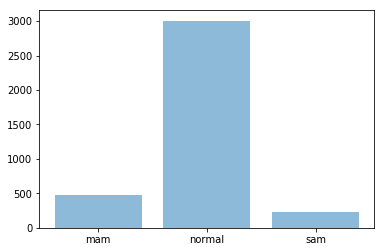

In [12]:
plt.bar(np.arange(len(names)),counts, align='center', alpha=0.5)
plt.xticks(np.arange(len(names)), names)

In [10]:
deselect_cols = ['photo_id','maln_mam','maln_normal','maln_sam','wfh','maln_class']

In [11]:
select = [x for x in merged_df.columns if x not in deselect_cols]
sam_train_features = sam_train.loc[:, select]
sam_validation_features = sam_validation.loc[:, select]
other_features=other_samples.loc[:, select]
other_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,gender_male,age_months
0,0.000000,3.874878,3.146828,0.085367,0.641485,1.040878,5.718253,12.905539,0.000000,0.047843,...,0.000000,0.029870,0.0,3.333816,0.678228,0.000000,2.517752,0.000000,0,53.0
1,0.685683,2.889598,0.000000,0.117376,0.021075,0.000000,6.720174,17.140646,0.000000,0.000000,...,0.000000,0.000000,0.0,7.517963,0.254039,0.000000,1.573691,0.404569,0,28.0
2,0.000000,0.000000,0.570655,0.000000,0.462136,3.889896,0.136814,3.245837,0.003812,1.094884,...,0.652646,0.000000,0.0,3.182923,0.000000,0.042585,0.372686,0.727551,1,27.0
3,0.000000,0.000000,3.916613,0.000000,0.127765,3.158929,0.174058,1.282006,0.000000,4.596279,...,2.383723,0.000000,0.0,2.081156,0.000000,0.000000,0.005886,0.000000,1,31.0
4,0.000000,0.000000,0.249367,0.055917,2.655461,1.068858,9.343360,9.615803,0.409722,0.488745,...,1.571785,0.381381,0.0,5.358086,0.000000,0.826179,0.544241,1.061325,1,50.0


# Split data into training and testing sets, then train model

In [12]:
whole_data=pd.concat([other_features, sam_train_features, sam_validation_features], axis=0)

In [13]:
### scale/standardize the features?
conv_scaler = StandardScaler().fit(whole_data)
sam_train_features_scaled = conv_scaler.transform(sam_train_features)
sam_validation_features_scaled=conv_scaler.transform(sam_validation_features)
other_features_scaled=conv_scaler.transform(other_features)

In [14]:
### Break data into training and test (stratified)
X_train1, X_test1, y_train1, y_test1 = train_test_split(other_features_scaled, target_other, test_size=0.2, random_state=42, 
                                                    stratify=target_other)

X_train=np.concatenate((X_train1,sam_train_features_scaled), axis=0)
y_train=np.concatenate((y_train1,target_sam_train), axis=0)

X_test=np.concatenate((X_test1,sam_validation_features_scaled), axis=0)
y_test=np.concatenate((y_test1,target_sam_validation), axis=0)

In [15]:
print(X_train.shape)
print(X_test.shape)

(2971, 2050)
(742, 2050)


In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

In [17]:
## compute class weight
w = compute_class_weight('balanced', np.unique(merged_df.maln_class), merged_df.maln_class)
w

array([2.61663143, 0.41173209, 5.28917379])

dense_model.compile(loss='categorical_crossentropy',
                               optimizer=Adam(lr=1e-4),
                               metrics=['accuracy'])

In [17]:
dense_model.fit(X_train,
                y_train,
                epochs=1000,
                batch_size=512,
                callbacks=[checkpoint, early_stop],
                shuffle=True,
                validation_data=(X_test, y_test),
                class_weight=meron._get_class_weights(meta_data.maln_class, neural_net=True),
                #class_weight=[3,0.3,10],
                verbose=1)

Train on 2971 samples, validate on 742 samples
Epoch 1/1000
2971/2971 [==============================] - 0s 50us/step - loss: 2.1639 - acc: 0.3874 - val_loss: 1.2225 - val_acc: 0.4003

Epoch 00001: val_loss did not improve from 1.19166
Epoch 2/1000
2971/2971 [==============================] - 0s 48us/step - loss: 2.2399 - acc: 0.3686 - val_loss: 1.2224 - val_acc: 0.3962

Epoch 00002: val_loss did not improve from 1.19166
Epoch 3/1000
2971/2971 [==============================] - 0s 57us/step - loss: 1.9159 - acc: 0.4130 - val_loss: 1.2195 - val_acc: 0.3922

Epoch 00003: val_loss did not improve from 1.19166
Epoch 4/1000
2971/2971 [==============================] - 0s 52us/step - loss: 1.9192 - acc: 0.3908 - val_loss: 1.2127 - val_acc: 0.3949

Epoch 00004: val_loss did not improve from 1.19166
Epoch 5/1000
2971/2971 [==============================] - 0s 50us/step - loss: 1.9053 - acc: 0.3780 - val_loss: 1.2056 - val_acc: 0.3868

Epoch 00005: val_loss did not improve from 1.19166
Epoch 6/

2971/2971 [==============================] - 0s 48us/step - loss: 1.2108 - acc: 0.4315 - val_loss: 1.0677 - val_acc: 0.4501

Epoch 00033: val_loss improved from 1.07025 to 1.06771, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 34/1000
2971/2971 [==============================] - 0s 51us/step - loss: 1.1883 - acc: 0.4382 - val_loss: 1.0646 - val_acc: 0.4474

Epoch 00034: val_loss improved from 1.06771 to 1.06460, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 35/1000
2971/2971 [==============================] - 0s 49us/step - loss: 1.2003 - acc: 0.4295 - val_loss: 1.0622 - val_acc: 0.4528

Epoch 00035: val_loss improved from 1.06460 to 1.06218, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 36/1000
2971/2971 [==============================] - 0s 49us/step - loss: 1.2446 - acc: 0.4453 - val_loss: 1.0595 - val_acc: 0.4542

Epoch 00036: val_loss improved from 1.06218 to 1.05947, saving model

Epoch 64/1000
2971/2971 [==============================] - 0s 46us/step - loss: 1.0184 - acc: 0.4881 - val_loss: 1.0013 - val_acc: 0.4960

Epoch 00064: val_loss improved from 1.00333 to 1.00127, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 65/1000
2971/2971 [==============================] - 0s 48us/step - loss: 0.9773 - acc: 0.4702 - val_loss: 1.0008 - val_acc: 0.4973

Epoch 00065: val_loss improved from 1.00127 to 1.00076, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 66/1000
2971/2971 [==============================] - 0s 50us/step - loss: 0.9818 - acc: 0.4756 - val_loss: 1.0001 - val_acc: 0.5027

Epoch 00066: val_loss improved from 1.00076 to 1.00006, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 67/1000
2971/2971 [==============================] - 0s 47us/step - loss: 0.9404 - acc: 0.4992 - val_loss: 0.9986 - val_acc: 0.5000

Epoch 00067: val_loss improved from 1.00006 to 0.99863

2971/2971 [==============================] - 0s 47us/step - loss: 0.8895 - acc: 0.5170 - val_loss: 0.9532 - val_acc: 0.5270

Epoch 00095: val_loss improved from 0.95427 to 0.95316, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 96/1000
2971/2971 [==============================] - 0s 47us/step - loss: 0.8534 - acc: 0.5278 - val_loss: 0.9509 - val_acc: 0.5229

Epoch 00096: val_loss improved from 0.95316 to 0.95087, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 97/1000
2971/2971 [==============================] - 0s 48us/step - loss: 0.8641 - acc: 0.5365 - val_loss: 0.9487 - val_acc: 0.5216

Epoch 00097: val_loss improved from 0.95087 to 0.94869, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 98/1000
2971/2971 [==============================] - 0s 51us/step - loss: 0.8347 - acc: 0.5382 - val_loss: 0.9464 - val_acc: 0.5283

Epoch 00098: val_loss improved from 0.94869 to 0.94638, saving model


Epoch 00125: val_loss improved from 0.90048 to 0.89939, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 126/1000
2971/2971 [==============================] - 0s 46us/step - loss: 0.7626 - acc: 0.5904 - val_loss: 0.8977 - val_acc: 0.5795

Epoch 00126: val_loss improved from 0.89939 to 0.89772, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 127/1000
2971/2971 [==============================] - 0s 47us/step - loss: 0.7224 - acc: 0.5907 - val_loss: 0.8962 - val_acc: 0.5836

Epoch 00127: val_loss improved from 0.89772 to 0.89621, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 128/1000
2971/2971 [==============================] - 0s 48us/step - loss: 0.7508 - acc: 0.5826 - val_loss: 0.8945 - val_acc: 0.5836

Epoch 00128: val_loss improved from 0.89621 to 0.89449, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 129/1000
2971/2971 [==============================] -

Epoch 156/1000
2971/2971 [==============================] - 0s 48us/step - loss: 0.6580 - acc: 0.6254 - val_loss: 0.8473 - val_acc: 0.6092

Epoch 00156: val_loss improved from 0.84867 to 0.84734, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 157/1000
2971/2971 [==============================] - 0s 56us/step - loss: 0.6906 - acc: 0.6284 - val_loss: 0.8462 - val_acc: 0.6078

Epoch 00157: val_loss improved from 0.84734 to 0.84619, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 158/1000
2971/2971 [==============================] - 0s 50us/step - loss: 0.6820 - acc: 0.6341 - val_loss: 0.8449 - val_acc: 0.6105

Epoch 00158: val_loss improved from 0.84619 to 0.84493, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 159/1000
2971/2971 [==============================] - 0s 51us/step - loss: 0.6751 - acc: 0.6257 - val_loss: 0.8437 - val_acc: 0.6186

Epoch 00159: val_loss improved from 0.84493 to 0.8

2971/2971 [==============================] - 0s 48us/step - loss: 0.5760 - acc: 0.6823 - val_loss: 0.8097 - val_acc: 0.6469

Epoch 00186: val_loss did not improve from 0.80940
Epoch 187/1000
2971/2971 [==============================] - 0s 57us/step - loss: 0.5979 - acc: 0.6664 - val_loss: 0.8100 - val_acc: 0.6456

Epoch 00187: val_loss did not improve from 0.80940
Epoch 188/1000
2971/2971 [==============================] - 0s 48us/step - loss: 0.5441 - acc: 0.6829 - val_loss: 0.8095 - val_acc: 0.6469

Epoch 00188: val_loss did not improve from 0.80940
Epoch 189/1000
2971/2971 [==============================] - 0s 50us/step - loss: 0.5824 - acc: 0.6876 - val_loss: 0.8088 - val_acc: 0.6456

Epoch 00189: val_loss improved from 0.80940 to 0.80880, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled).h5
Epoch 190/1000
2971/2971 [==============================] - 0s 47us/step - loss: 0.5778 - acc: 0.6802 - val_loss: 0.8084 - val_acc: 0.6442

Epoch 00190: val_loss improved f

In [15]:
### best yet
dense_model=load_model('dense_model_resnetfeats_128_8(dropout05_filtered).h5')

# Confusion matrix


In [18]:
prediction=dense_model.predict(X_test, verbose=1)

742/742 [==============================] - 0s 140us/step


In [19]:
pred_classes = prediction.argmax(axis=-1)
true_classes=y_test.argmax(axis=-1)

In [20]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [21]:
cnf_matrix=confusion_matrix(true_classes, pred_classes)

Confusion matrix, without normalization
[[ 30  59   6]
 [118 456  27]
 [ 17  29   0]]


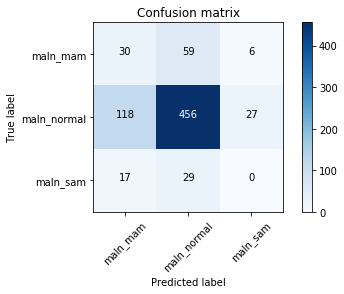

In [22]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

Confusion matrix, without normalization
[[ 18  71   6]
 [ 85 498  18]
 [  0   8  39]]


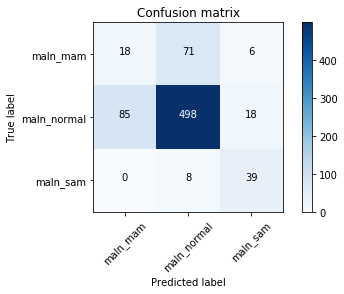

In [34]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

In [48]:
sam_id=pd.read_csv('/data/meron/sam_photo_ids.csv')
sam_id.shape

(117, 1)

In [49]:
flip_name=[]
for row in sam_id['photo_id']:
    base_name=row.split('.')[0]
    sam_clahe=base_name+'_flip.jpg'
    flip_name.append(sam_clahe)

In [52]:
len(flip_name)

117